In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

import torch
import torch.nn as nn
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

file_path = 'C:\\Users\\Dell\\Downloads\\Garstec_AS09_chiara.hdf5'

In [3]:
# selecting another track with an initial mass as close to track 00001 as possible.

age_data_list = []
Teff_data_list = []
LPhot_data_list = []
mass_data_list = []
FeH_data_list = []
Gaia_data_list = []

with h5py.File(file_path, 'r') as f:
    grid = f['grid']
    tracks = grid['tracks']
    
    selected_tracks = []
    
    
    for track_name in tracks:
        track = tracks[track_name]
        
        # Check for the criteria on 'massini' and 'alphaMLT'
        if 'massini' in track and track['massini'].size > 0:
            massini_value = track['massini'][()][0]
        else:
            massini_value = 0  # Outside our range

        if massini_value == 1.1:
            selected_tracks.append(track)
            print(track_name)
            # Access and collect the data for each track
            teff_data = track['Teff'][:] 
            luminosity_data = track['LPhot'][:]
            age_data = track['age'][:]
            mass_data = track['massini'][:] 
            FeH_data = track['FeH'][:]
            Gaia_data = track['G_GAIA'][:]
            
            # Append to lists
            age_data_list.append(age_data)
            Teff_data_list.append(teff_data)
            LPhot_data_list.append(luminosity_data)
            mass_data_list.append(mass_data)
            FeH_data_list.append(FeH_data)
            Gaia_data_list.append(Gaia_data)

print(f"Total selected tracks: {len(selected_tracks)}")



track00001
track01364
track02046
track02731
track04094
track04097
track04779
track05460
track06145
track06827
track08190
track08193
track09556
Total selected tracks: 13


In [10]:
# Cherry picking two with mass_ini = 1.1: track 00001 and track 01364:

track_number1 = "00001"
with h5py.File(file_path, 'r') as f:
    path_temp1 = f"grid/tracks/track{track_number1}/Teff"
    path_lum1 = f"grid/tracks/track{track_number1}/LPhot"
    path_age1 = f"grid/tracks/track{track_number1}/age"
    path_mass1 = f"grid/tracks/track{track_number1}/massini"
    path_FeH = f"grid/tracks/track{track_number1}/FeH"
    path_Gaia = f"grid/tracks/track{track_number1}/G_GAIA"
    Teff1 = f[path_temp1][:]
    LPhot1 = f[path_lum1][:]
    FeH1 = f[path_FeH][:]
    Gaia1 = f[path_Gaia][:]
    age1 = f[path_age1][:]
    mass1 = f[path_mass1][:]

track_number2 = "01364"
with h5py.File(file_path, 'r') as f:
    path_temp2 = f"grid/tracks/track{track_number2}/Teff"
    path_lum2 = f"grid/tracks/track{track_number2}/LPhot"
    path_age2 = f"grid/tracks/track{track_number2}/age"
    path_mass2 = f"grid/tracks/track{track_number2}/massini"
    path_FeH2 = f"grid/tracks/track{track_number2}/FeH"
    path_Gaia2 = f"grid/tracks/track{track_number2}/G_GAIA"
    Teff2 = f[path_temp2][:]
    LPhot2 = f[path_lum2][:]
    FeH2 = f[path_FeH2][:]
    Gaia2 = f[path_Gaia2][:]
    age2 = f[path_age2][:]
    mass2 = f[path_mass2][:]



Teff = np.concatenate((Teff1, Teff2), axis=0)
LPhot = np.concatenate((LPhot1, LPhot2), axis=0)
age = np.concatenate((age1, age2), axis=0)
mass = np.concatenate((mass1, mass2), axis=0)
FeH = np.concatenate((FeH1, FeH2), axis=0)
Gaia = np.concatenate((Gaia1, Gaia2), axis=0)

inputs = np.column_stack((age, mass))
outputs = np.column_stack((Teff, LPhot, FeH, Gaia))

print("Inputs shape:", inputs.shape)  # Should be (num_samples, 2)
print("Outputs shape:", outputs.shape)  # Should be (num_samples, 2)

Inputs shape: (1488, 2)
Outputs shape: (1488, 4)


In [4]:
# Attempting with 13 tracks collected:

age_data_scaled = np.concatenate(age_data_list).reshape(-1, 1)
Teff_data_scaled = np.concatenate(Teff_data_list).reshape(-1, 1)
LPhot_data_scaled = np.concatenate(LPhot_data_list).reshape(-1, 1)
mass_data_scaled = np.concatenate(mass_data_list).reshape(-1, 1)
FeH_data_scaled = np.concatenate(FeH_data_list).reshape(-1, 1)
Gaia_data_scaled = np.concatenate(Gaia_data_list).reshape(-1, 1)

inputs_13 = np.column_stack((age_data_scaled, mass_data_scaled))
outputs_13 = np.column_stack((Teff_data_scaled, LPhot_data_scaled, FeH_data_scaled, Gaia_data_scaled))

In [11]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(inputs, outputs, test_size=0.2, random_state=1)

X_scaler = StandardScaler()
Y_scaler = StandardScaler()

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_scaler.fit_transform(X_train)).view(-1, 2)
X_test = torch.FloatTensor(X_scaler.transform(X_test)).view(-1, 2)
Y_train = torch.FloatTensor(Y_scaler.fit_transform(Y_train))
Y_test = torch.FloatTensor(Y_scaler.transform(Y_test))

print(len(X_train), len(Y_train))
print("X_train shape:", X_train.shape)
print("Y_train shape:", Y_train.shape)
#print(X_train, Y_train)



1190 1190
X_train shape: torch.Size([1190, 2])
Y_train shape: torch.Size([1190, 4])


In [12]:
# Define a simple neural network model
class StellarModel(nn.Module):
    def __init__(self):
        super(StellarModel, self).__init__()
        self.fc1 = nn.Linear(2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 4)  

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the model, define loss and optimizer
model = StellarModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch [1000/10000], Train Loss: 0.0040, Test Loss: 0.0045
Epoch [2000/10000], Train Loss: 0.0022, Test Loss: 0.0025
Epoch [3000/10000], Train Loss: 0.0021, Test Loss: 0.0025
Epoch [4000/10000], Train Loss: 0.0015, Test Loss: 0.0018
Epoch [5000/10000], Train Loss: 0.0013, Test Loss: 0.0016
Epoch [6000/10000], Train Loss: 0.0018, Test Loss: 0.0023
Epoch [7000/10000], Train Loss: 0.0012, Test Loss: 0.0015
Epoch [8000/10000], Train Loss: 0.0012, Test Loss: 0.0015
Epoch [9000/10000], Train Loss: 0.0012, Test Loss: 0.0014
Epoch [10000/10000], Train Loss: 0.0012, Test Loss: 0.0014


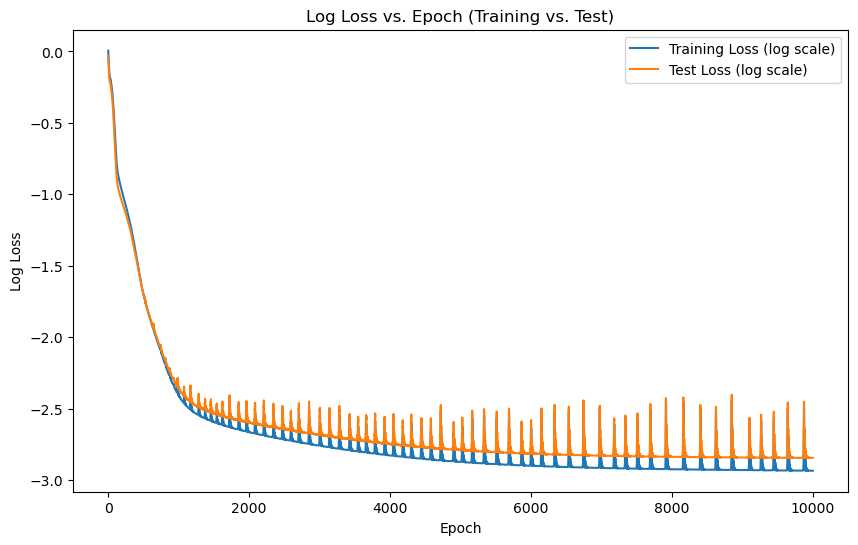

In [13]:
num_epochs = 10000
train_loss = []  
test_loss = []   

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    # Forward pass for training data
    outputs_train = model(X_train)
    epoch_train_loss = criterion(outputs_train, Y_train)

    # Backward pass and optimization for training data
    optimizer.zero_grad()  # Clear gradients
    epoch_train_loss.backward()  # Backpropagation
    optimizer.step()       # Update weights

    # Forward pass for test data
    model.eval()  # Set the model to evaluation mode (disables dropout, etc.)
    with torch.no_grad():
        outputs_test = model(X_test)
        epoch_test_loss = criterion(outputs_test, Y_test)  # Calculate test loss
    
    # Store the losses for plotting
    train_loss.append(epoch_train_loss.item())
    test_loss.append(epoch_test_loss.item())

    # Print progress every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {epoch_train_loss.item():.4f}, Test Loss: {epoch_test_loss.item():.4f}')

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(np.log10(train_loss), label='Training Loss (log scale)')
plt.plot(np.log10(test_loss), label='Test Loss (log scale)')
plt.xlabel('Epoch')
plt.ylabel('Log Loss')
plt.title('Log Loss vs. Epoch (Training vs. Test)')
plt.legend()
plt.show()

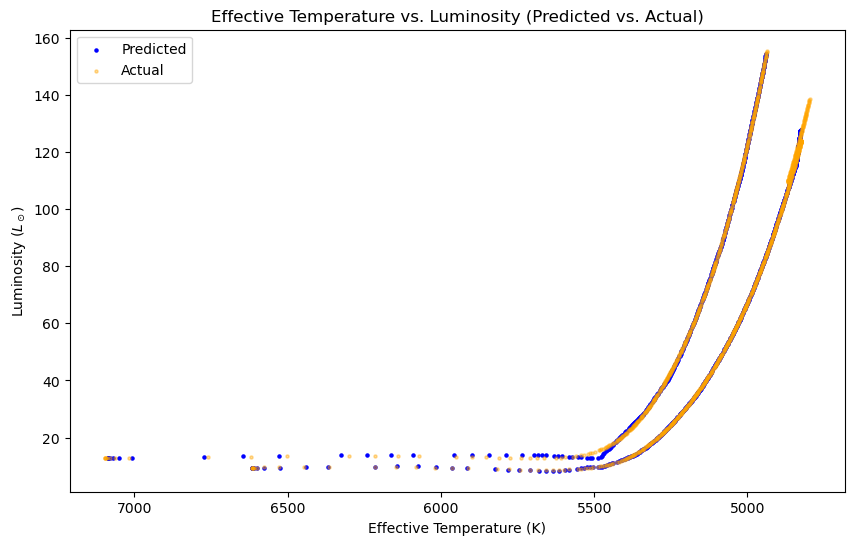

In [14]:
model.eval()
with torch.no_grad():
    # Make predictions for both training and test sets
    predictions_train = model(X_train).numpy()
    predictions_train = Y_scaler.inverse_transform(predictions_train)
    y_train_actual = Y_scaler.inverse_transform(Y_train.numpy())

    predictions_test = model(X_test).numpy()
    predictions_test = Y_scaler.inverse_transform(predictions_test)
    y_test_actual = Y_scaler.inverse_transform(Y_test.numpy())


predicted_temperature_train = predictions_train[:, 0]
predicted_luminosity_train = predictions_train[:, 1]
predicted_FeH_train = predictions_train[:, 2]
predicted_Gaia_train = predictions_train[:, 3]
actual_temperature_train = y_train_actual[:, 0]
actual_luminosity_train = y_train_actual[:, 1]
actual_FeH_train = y_train_actual[:, 2]
actual_Gaia_train = y_train_actual[:, 3]

predicted_temperature_test = predictions_test[:, 0]
predicted_luminosity_test = predictions_test[:, 1]
predicted_FeH_test = predictions_test[:, 2]
predicted_Gaia_test = predictions_test[:, 3]
actual_temperature_test = y_test_actual[:, 0]
actual_luminosity_test = y_test_actual[:, 1]
actual_FeH_test = y_test_actual[:, 2]
actual_Gaia_test = y_test_actual[:, 3]

# Plotting the combined data
plt.figure(figsize=(10, 6))
plt.scatter(predicted_temperature_train, predicted_luminosity_train, s=5, color='blue', marker='o', alpha=1, label='Predicted')
plt.scatter(actual_temperature_train, actual_luminosity_train, s=5, color='orange', marker='o', alpha=0.4, label='Actual')
plt.gca().invert_xaxis()
plt.xlabel("Effective Temperature (K)")
plt.ylabel("Luminosity ($L_\odot$)")
plt.title("Effective Temperature vs. Luminosity (Predicted vs. Actual)")
plt.legend()
plt.show()

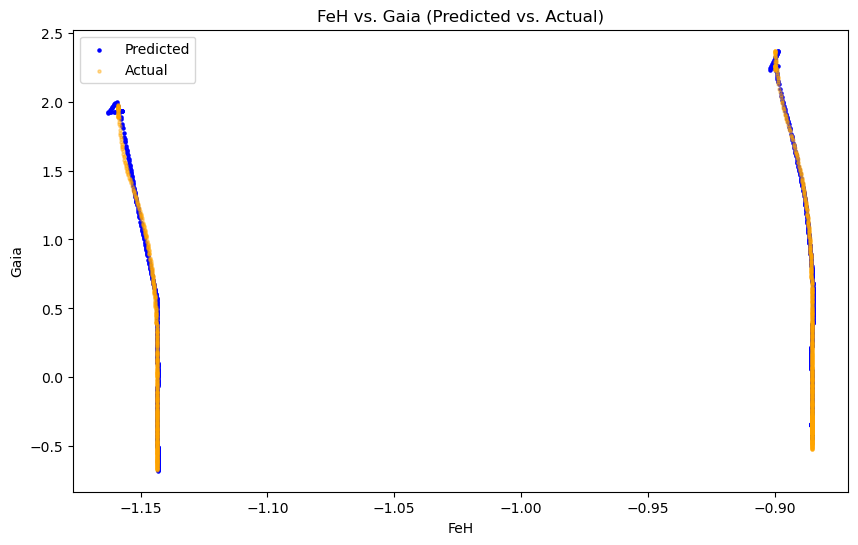

In [185]:
plt.figure(figsize=(10, 6))
plt.scatter(predicted_FeH_train, predicted_Gaia_train, s=5, color='blue', marker='o', alpha=1, label='Predicted')
plt.scatter(actual_FeH_train, actual_Gaia_train, s=5, color='orange', marker='o', alpha=0.4, label='Actual')
plt.xlabel("FeH")
plt.ylabel("Gaia")
plt.title("FeH vs. Gaia (Predicted vs. Actual)")
plt.legend()
plt.show()